In [1]:
import os

import numpy as np
import torch
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quad_drift
from phase_space_reconstruction.virtual.scans import run_quad_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.train import train_1d_scan

from bmadx.plot import plot_projections
from phase_space_reconstruction.visualization import plot_scan_data, plot_predicted_screens

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# create synthetic ground truth beam from base and transform yaml files
gt_beam = torch.load("../../examples/synthetic_6d/data/gaussian_beam.pt")
gt_beam.data = gt_beam.data

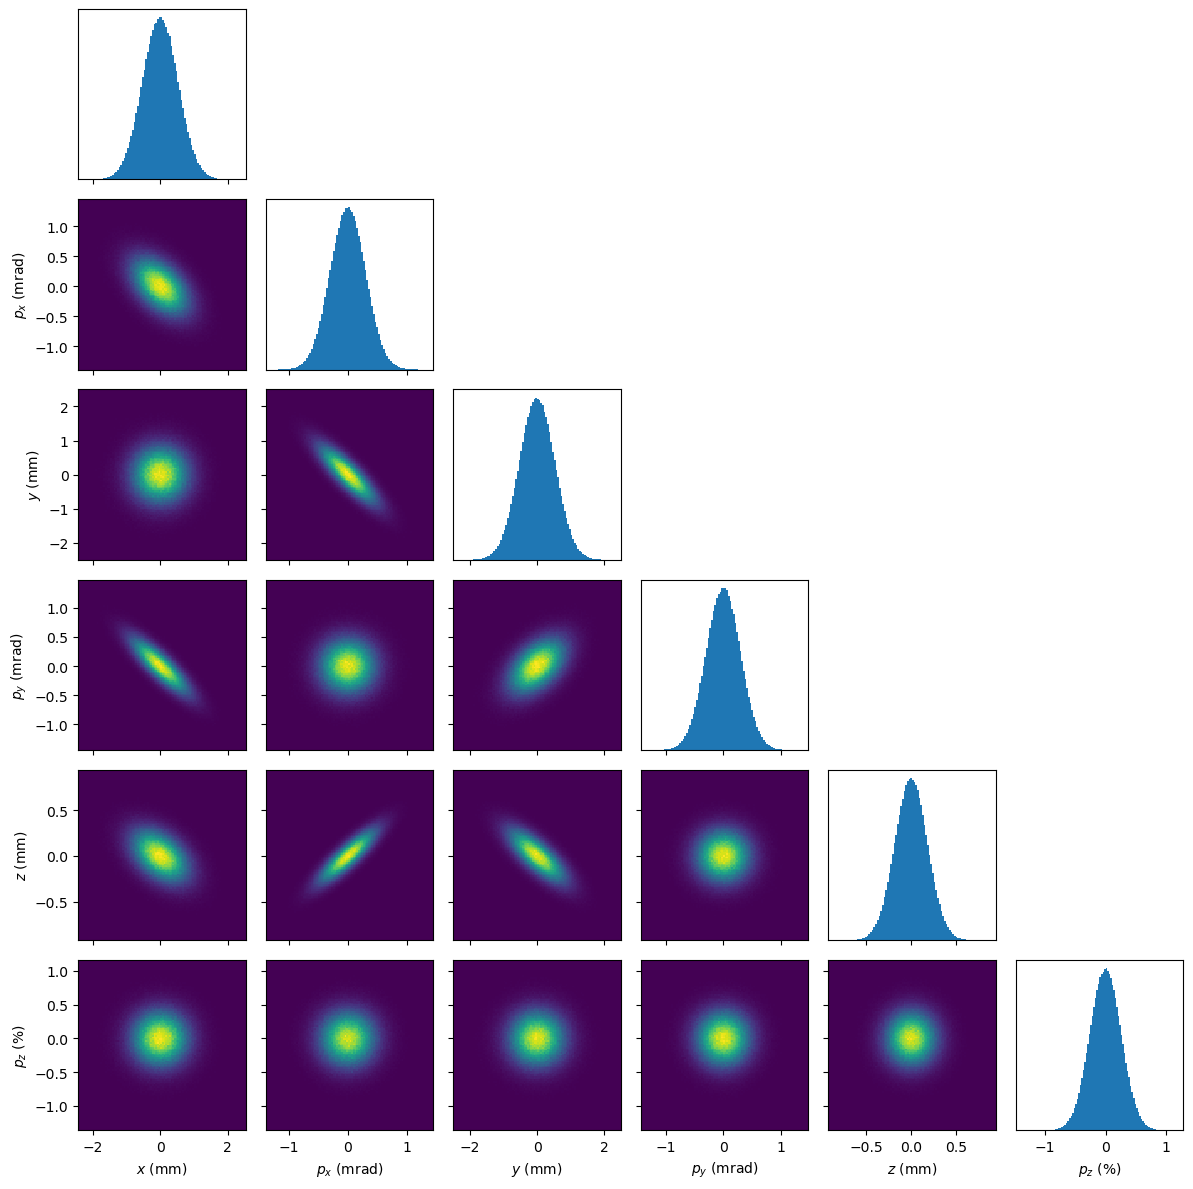

In [3]:
# plot synthetic ground truth beam projections
fig, ax = plot_projections(gt_beam, bins=100)
plt.show()

In [4]:
# diagnostic beamline:
lattice = quad_drift()

# design momentum (eV)
p0c = 10.0e6

# quadrupole strengths for scan (reshape as: n_quad_strengths x n_images_per_quad_strength x 1)
n_ks = 4
ks = torch.linspace(-15, 25, n_ks).reshape((n_ks,1,1))

# split in training and testing sets
train_ks = ks[::2]
test_ks = ks[1::2]

# create diagnostic screen:
bins = torch.linspace(-5, 5, 200) * 1e-3
bandwidth = (bins[1]-bins[0]) / 2
screen = ImageDiagnostic(bins, bins, bandwidth)

In [5]:
# generate and save train and test datasets
train_dset = run_quad_scan(gt_beam, lattice, screen, train_ks, save_as=os.path.join('data', 'train.dset'))
test_dset = run_quad_scan(gt_beam, lattice, screen, test_ks, save_as=os.path.join('data', 'test.dset'))

dataset saved as 'data/train.dset'
dataset saved as 'data/test.dset'


image size = 10 x 10 mm
test samples boxed in orange


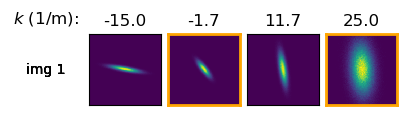

In [6]:
# plot generated datasets
fig, ax = plot_scan_data(train_dset, test_dset, bins, bins)
plt.show()

In [7]:
from phase_space_reconstruction.modeling import (
    NNTransform,
    InitialBeam,
    VariationalPhaseSpaceReconstructionModel,
    ImageDataset,
    PhaseSpaceReconstructionModel3D,
    ImageDataset3D, SextPhaseSpaceReconstructionModel
)
from phase_space_reconstruction.losses import normalize_images
from models import IndependentVariationalNN
import torch
from torch.utils.data import DataLoader



"""
Trains beam model by scanning an arbitrary lattice.
Note: as of now, the quadrupole that is scanned should
be the first element of the lattice.

Parameters
----------
train_data: ImageDataset
    training data

lattice: bmadx TorchLattice
    diagnostics lattice. First element is the scanned quad.

screen: ImageDiagnostic
    screen diagnostics

Returns
-------
predicted_beam: bmadx Beam
    reconstructed beam

"""

# Device selection:
DEVICE = torch.device("cuda")
print(f'Using device: {DEVICE}')

ks = train_dset.k.to(DEVICE)
imgs = train_dset.images.to(DEVICE)

train_dset_device = ImageDataset(ks, imgs)
train_dataloader = DataLoader(
    train_dset_device,
    batch_size=1,
    shuffle=True
    )

# create phase space reconstruction model
nn_transformer = IndependentVariationalNN(6, 50, output_scale=1e-3)
nn_beam = InitialBeam(
    nn_transformer,
    torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6)),
    10000,
    p0c=torch.tensor(p0c),
)
model = VariationalPhaseSpaceReconstructionModel(
    lattice.copy(),
    screen,
    nn_beam
)

Using device: cuda


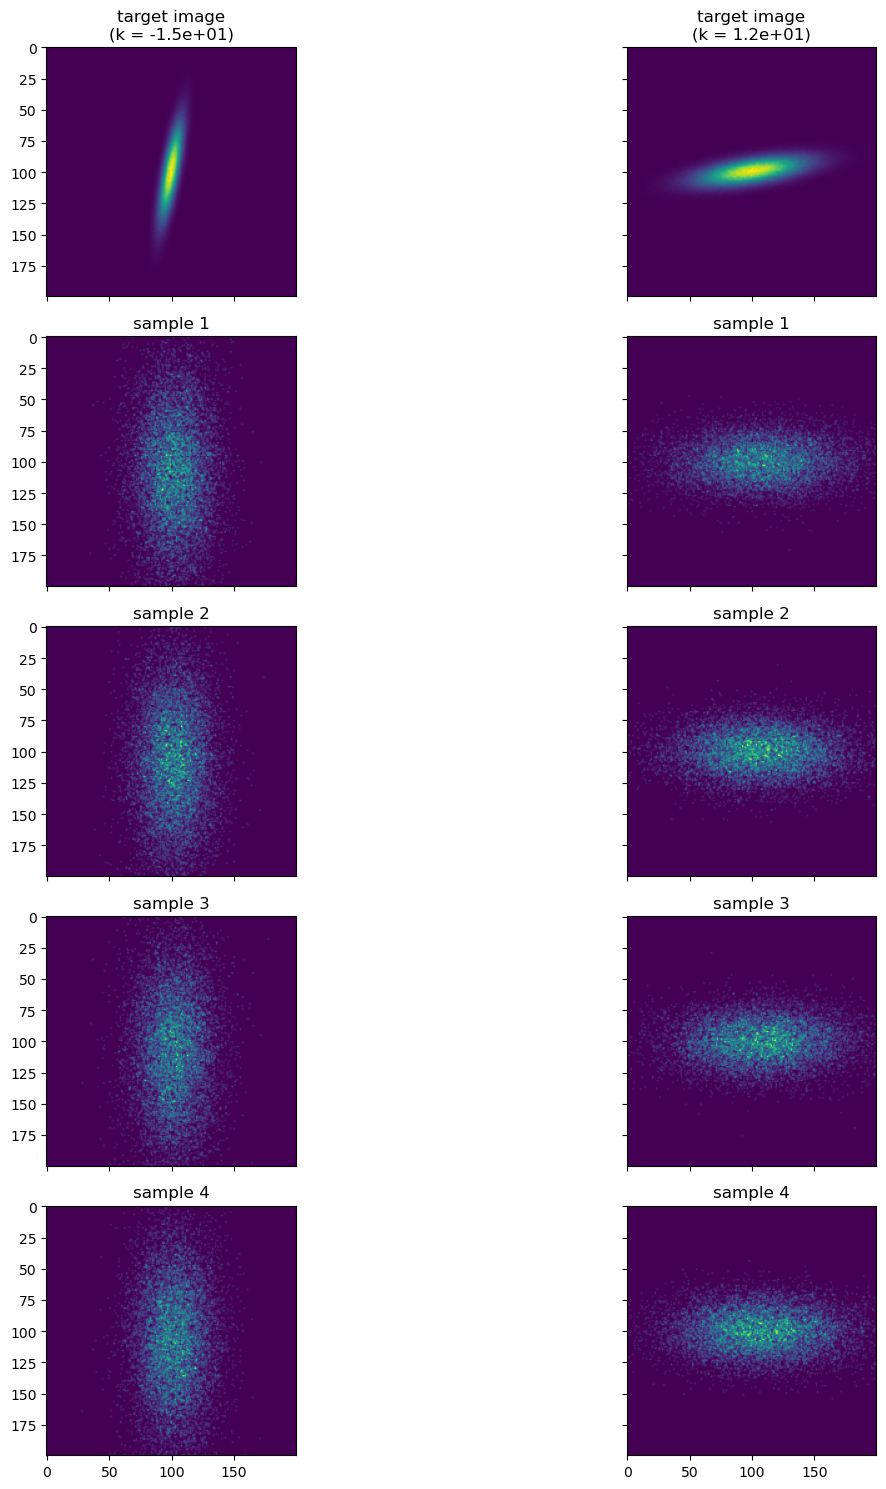

In [8]:
# predict images
output = model(ks.cpu(), 0)

# calculate image loss
target_images = normalize_images(imgs).cpu()
pred_images = normalize_images(output).detach()

fig,ax = plt.subplots(5,len(target_images),sharey="all",sharex="all",figsize=(15,15))
for i in range(len(target_images)):
    ax[0,i].set_title(f"target image\n(k = {float(ks[i]):.2})")
    ax[0,i].imshow(target_images[i,0])

    for j in range(1, len(ax)):
        ax[j,i].imshow(pred_images[i,j])
        ax[j,i].set_title(f"sample {j}")

fig.tight_layout()
fig.savefig("untrained_pred_measurement_comparison.png", dpi=300)

In [9]:
model = model.to(DEVICE)

# train model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss_track = []
for i in range(3000):
    k, target_images = ks, imgs
    optimizer.zero_grad()
    output = model(k, 0)

    # calculate image loss
    target_images = normalize_images(target_images)
    pred_images = normalize_images(output)
    #assert target_images.shape == pred_images.shape
    image_loss = torch.mean(torch.abs(target_images - pred_images)) * 1e5

    # calculate uncertainty loss
    prior_loss = (
            model.beam.transformer.std(model.beam.base_beam.data)[:,:4] - 5e-3
    ).pow(2).mean() * 2e5


    loss = image_loss + prior_loss
    loss.backward()
    optimizer.step()

    loss_track += [torch.stack([loss, image_loss, prior_loss])]

    if i % 100 == 0:
        print(i, loss, image_loss, prior_loss)

loss_track = torch.stack(loss_track).detach()

0 tensor(6.5234, device='cuda:0', grad_fn=<AddBackward0>) tensor(2.9136, device='cuda:0', grad_fn=<MulBackward0>) tensor(3.6098, device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(3.0203, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8125, device='cuda:0', grad_fn=<MulBackward0>) tensor(1.2078, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(2.9853, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7726, device='cuda:0', grad_fn=<MulBackward0>) tensor(1.2126, device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(2.9742, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8230, device='cuda:0', grad_fn=<MulBackward0>) tensor(1.1512, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(2.9389, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.7527, device='cuda:0', grad_fn=<MulBackward0>) tensor(1.1862, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(2.8804, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.8408, device='cuda:0', grad_fn=<MulBackward0>) tensor(1.0396, device='cud

In [10]:
loss_track.shape

torch.Size([3000, 3])

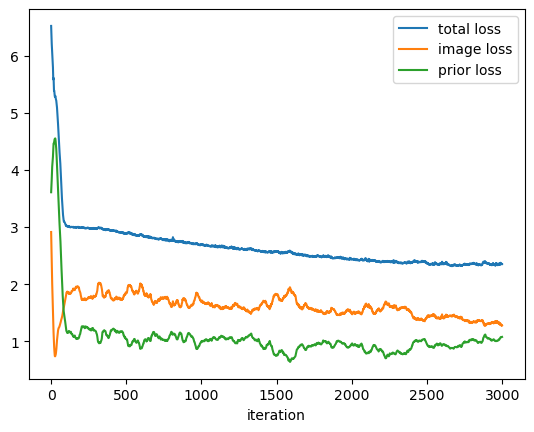

In [11]:
fig2, ax2 = plt.subplots()
ax2.plot(loss_track.cpu().numpy(),label=["total loss", "image loss", "prior loss"])
ax2.set_xlabel("iteration")
ax2.legend()
#fig2.savefig(base_fname + "loss_curves.png", dpi=300)


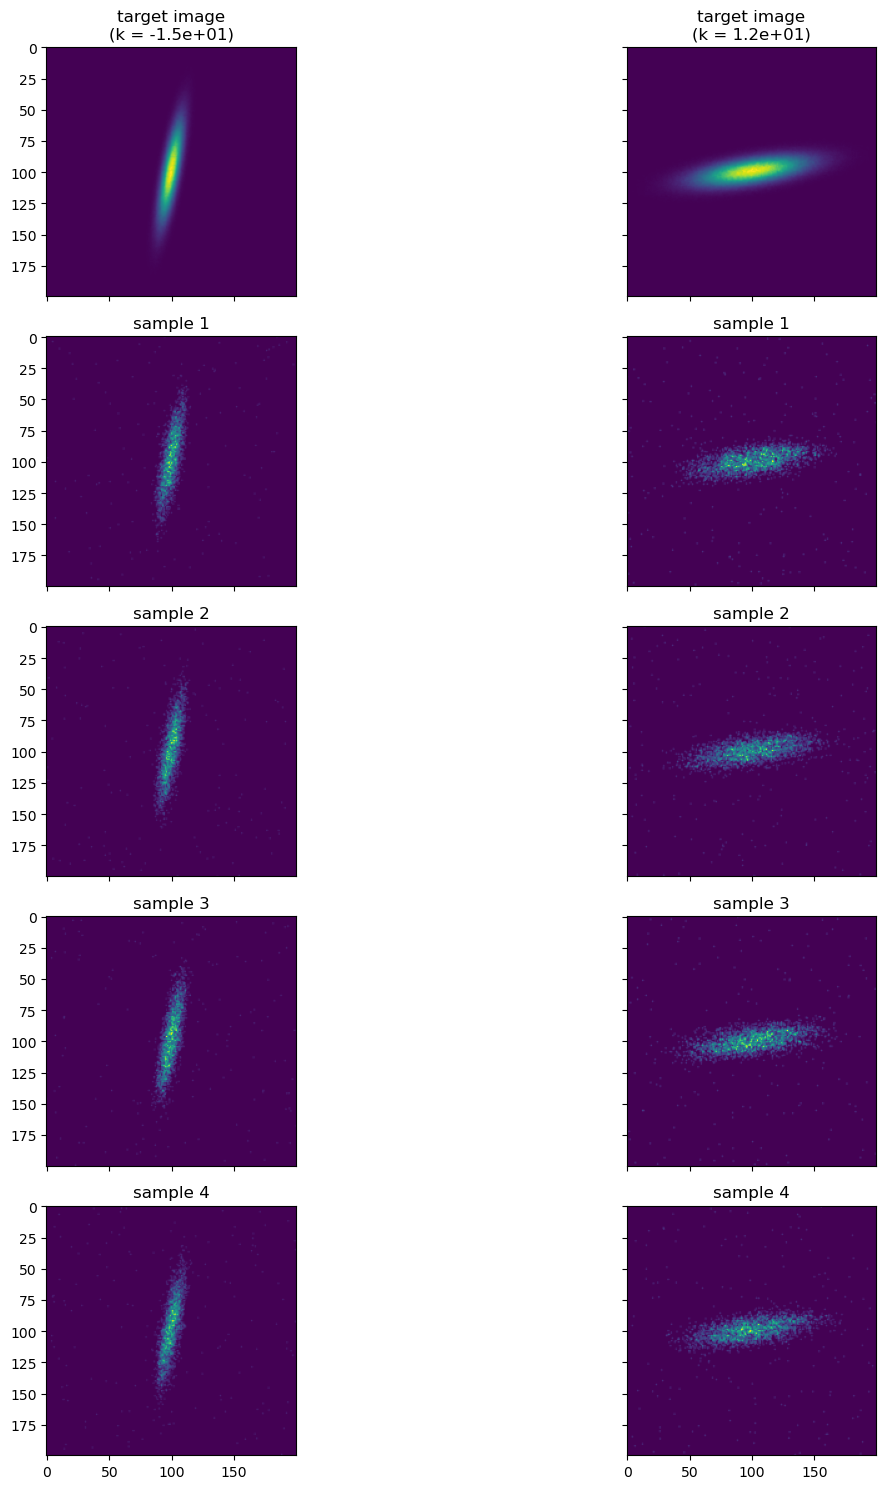

In [12]:
# predict images
model = model.cpu()
output = model(ks.cpu(), 0)

# calculate image loss
target_images = normalize_images(imgs).cpu()
pred_images = normalize_images(output).detach()

fig,ax = plt.subplots(5,len(target_images),sharey="all",sharex="all",figsize=(15,15))
for i in range(len(target_images)):
    ax[0,i].set_title(f"target image\n(k = {float(ks[i]):.2})")
    ax[0,i].imshow(target_images[i,0])

    for j in range(1, len(ax)):
        ax[j,i].imshow(pred_images[i,j])
        ax[j,i].set_title(f"sample {j}")

fig.tight_layout()
#fig.savefig(base_fname + "trained_pred_measurement_comparison.png", dpi=300)

In [13]:
import copy
model_copy = copy.deepcopy(model)
model = model.to('cpu')
model_copy.beam.set_base_beam(
                    1_000_000, p0c=torch.tensor(p0c)
                )
predicted_beam = model_copy.beam.forward().detach_clone()

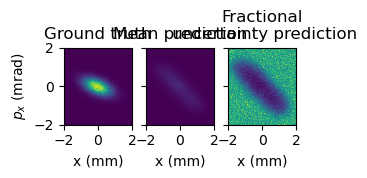

In [28]:
import numpy as np
# plot 2d histogram of x-px phase space
x, px = predicted_beam.x.numpy(), predicted_beam.px.numpy()

histograms = []
hist_range = np.array(((-5e-3,5e-3),(-5e-3,5e-3))) * 1e3 * 2/5
bins=200

gt_H, x_edges, y_edges = np.histogram2d(gt_beam.x*1e3, gt_beam.px*1e3, range=hist_range,
                                            bins=bins)

for i in range(len(x)):
    H, x_edges, y_edges = np.histogram2d(x[i] * 1e3, px[i]*1e3, range=hist_range,
                                         bins=bins)
    xcenters = (x_edges[:-1] + x_edges[1:]) / 2
    ycenters = (y_edges[:-1] + y_edges[1:]) / 2

    histograms += [H]

histograms = np.stack(histograms)
hist_mean = np.mean(histograms, axis=0)
hist_std = np.std(histograms, axis=0)

fig,ax = plt.subplots(1,3, figsize=(12,3),sharey="all",sharex="all")

ax[0].set_title("Ground truth")
ax[0].set_xlabel("x (mm)")
ax[0].set_ylabel("$p_x$ (mrad)")
c =ax[0].pcolor(xcenters, ycenters, gt_H.T, vmax=np.max(gt_H), rasterized=True)
#fig.colorbar(c)

ax[1].set_title("Mean prediction")
ax[1].set_xlabel("x (mm)")
c =ax[1].pcolor(xcenters, ycenters, hist_mean.T, vmax=np.max(gt_H), rasterized=True)
#fig.colorbar(c)

ax[2].set_title("Fractional\n uncertainty prediction")
ax[2].set_xlabel("x (mm)")
c = ax[2].pcolor(xcenters, ycenters, hist_std.T / (hist_mean.T +1), rasterized=True)
#fig.colorbar(c)

fig.set_size_inches(3,1)

fig.savefig("phase_space_pred2.svg", dpi=300)

In [15]:
model.beam.transformer.std(model.beam.base_beam.data)

tensor([[3.0599e-04, 2.6942e-04, 4.5028e-04, 1.5848e-04, 3.1424e-04, 3.9294e-04],
        [5.1197e-03, 5.0731e-03, 5.1986e-03, 5.0023e-03, 1.3722e-03, 8.6914e-06],
        [5.1231e-03, 5.0762e-03, 5.2023e-03, 5.0054e-03, 1.3719e-03, 8.6599e-06],
        ...,
        [3.2760e-04, 3.1822e-04, 5.5160e-04, 1.9122e-04, 2.9835e-04, 3.3348e-04],
        [3.1118e-04, 2.7865e-04, 4.7100e-04, 1.6492e-04, 3.1121e-04, 3.8247e-04],
        [5.1149e-03, 5.0686e-03, 5.1931e-03, 4.9977e-03, 1.3726e-03, 8.7373e-06]],
       grad_fn=<MulBackward0>)

In [16]:
model.beam.transformer.mean(model.beam.base_beam.data)


tensor([[ 1.0826e+00, -1.0202e+00,  1.0350e+00, -6.0584e-01,  1.0446e+00,
          5.4298e+02],
        [-2.6831e-01,  3.3742e-02, -4.2672e-01, -1.9846e-01, -7.4234e-01,
         -6.7968e+02],
        [-2.6863e-01,  3.4021e-02, -4.2701e-01, -1.9832e-01, -7.4241e-01,
         -6.7970e+02],
        ...,
        [-2.3218e-01,  1.7469e-01, -1.5228e-01,  1.1587e-01,  1.0826e+00,
          6.0660e+02],
        [ 7.3552e-01, -7.0330e-01,  7.3894e-01, -4.2172e-01,  9.8553e-01,
          5.3447e+02],
        [-2.6516e-01,  3.0758e-02, -4.2397e-01, -2.0006e-01, -7.4173e-01,
         -6.7945e+02]], grad_fn=<AddmmBackward0>)

In [17]:
model_copy.beam.set_base_beam(
                    1_000_000, p0c=torch.tensor(p0c)
                )
predicted_beam = model_copy.beam.forward().detach_clone()

In [18]:
predicted_beam.x.shape

torch.Size([50, 1000000])